In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

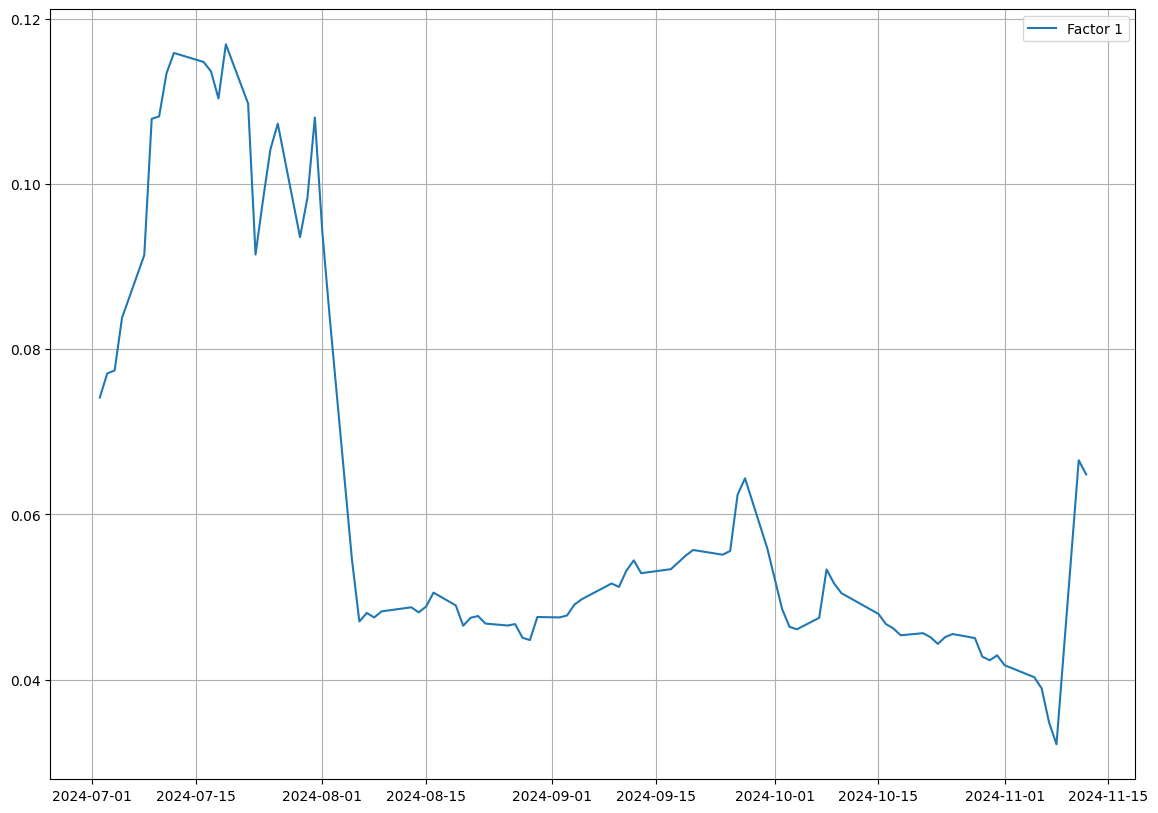

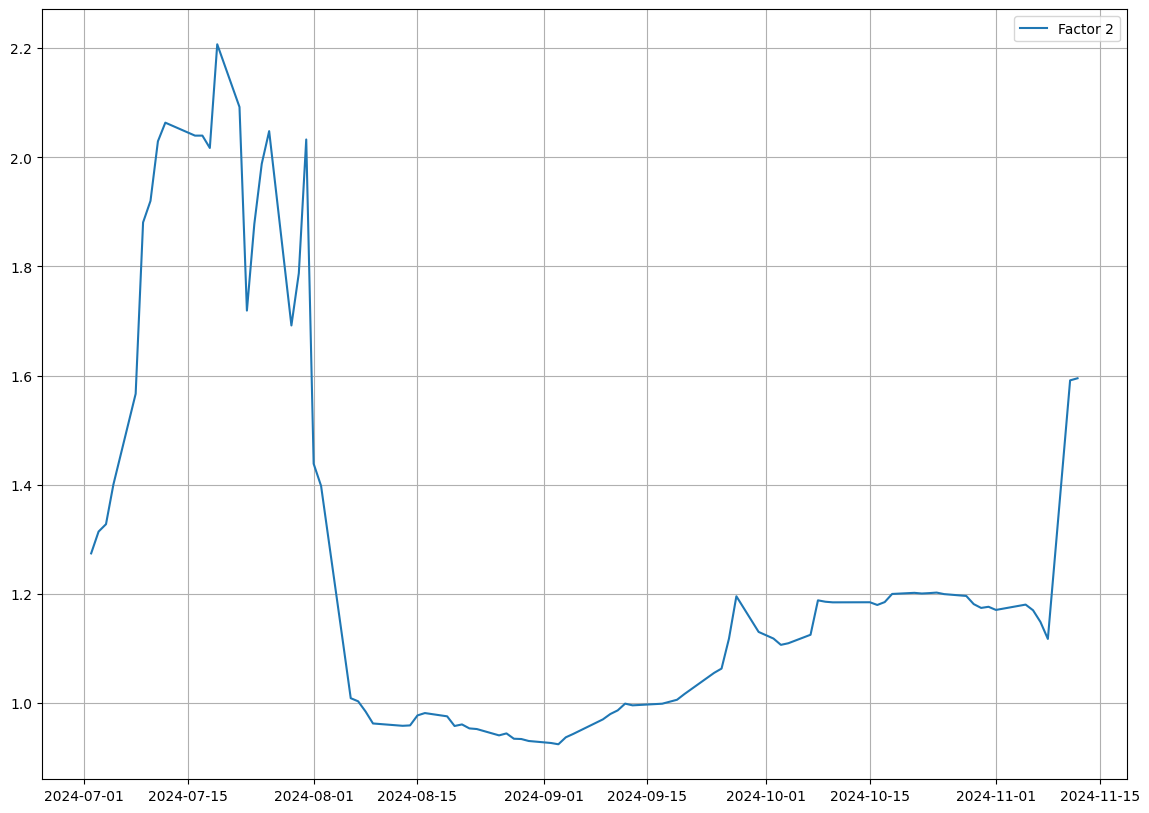

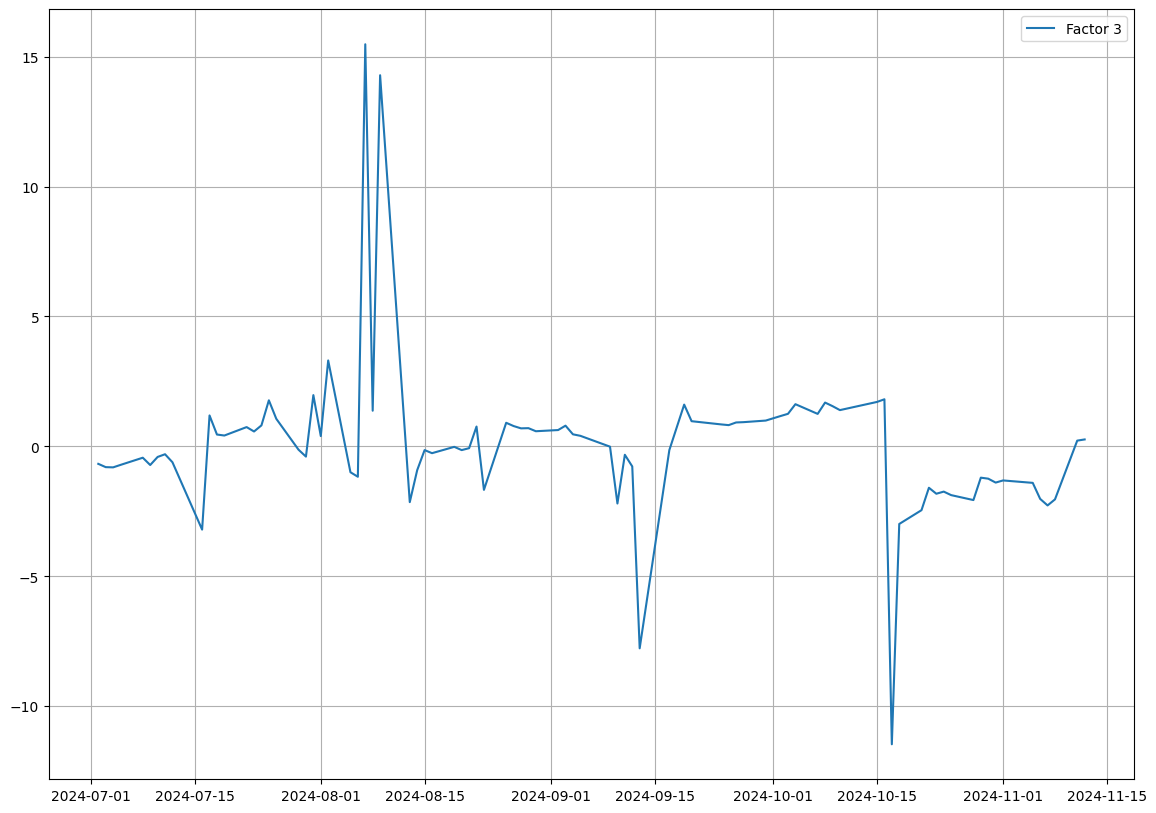

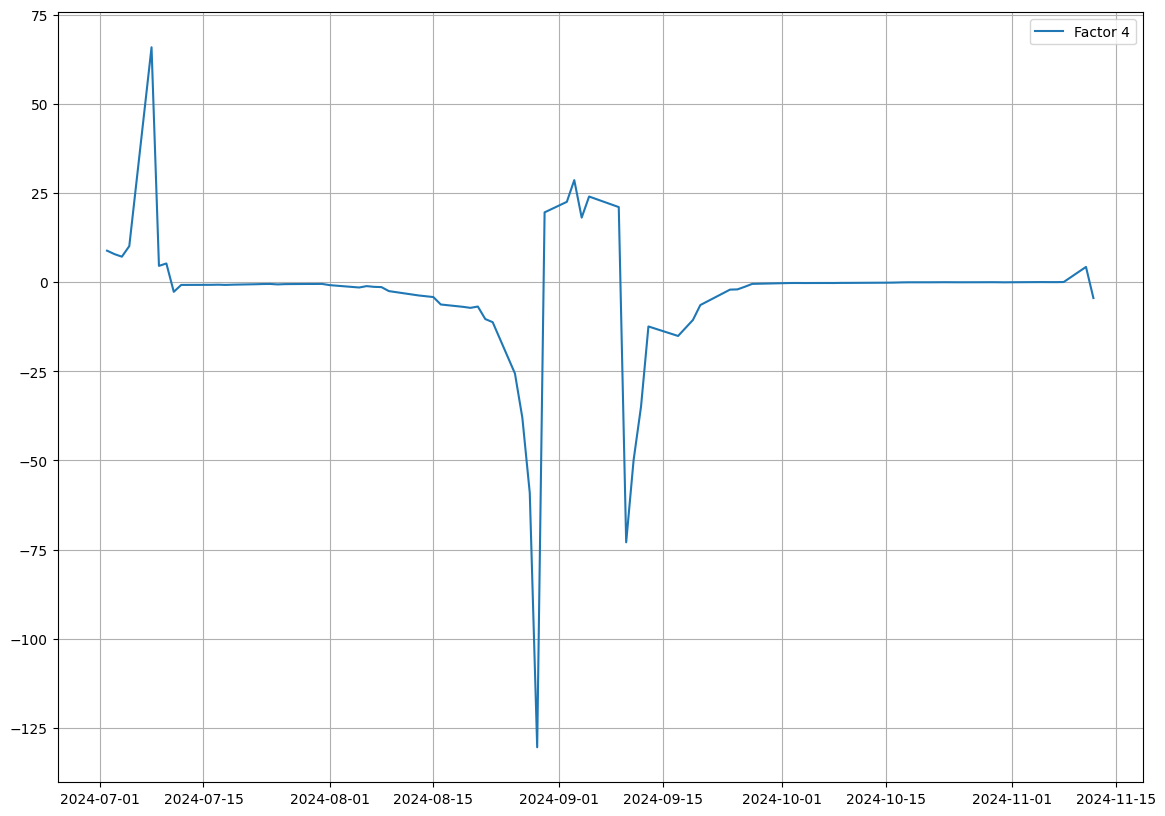

In [7]:
folder_path = "/Users/arohansharma/Desktop/Campbell-Project-Lab-Factor-PCA-PAF/asia_returns_output/factorLoadings"
files = [f if '.xlsx' in f else '' for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
files.remove('')
files.sort()
dates = [pd.Timestamp(f.split('.')[0]) for f in files]

factors = ['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4']

factor_loadings = {}
factor_loadings_in_hk = {}

for factor in factors:
    factor_loadings_in_hk[factor] = []

for date, file in zip(dates, files):
    factor_loadings[date] = pd.read_excel(os.path.join(folder_path, file), header=0)
    factor_loadings[date]['Exchange'] = factor_loadings[date]['Ticker'].str[:2]
    factor_loadings_by_exchange = factor_loadings[date].groupby(
        'Exchange').sum()[['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4']].loc['HK']
    for factor in factors:
        factor_loadings_in_hk[factor].append(factor_loadings_by_exchange.loc[factor]/factor_loadings[date][factor].sum())

for factor in factors:

    plt.figure(figsize=(14, 10))
    
    factor_loadings_in_hk[factor] = pd.Series(factor_loadings_in_hk[factor], index=dates)
    factor_loadings_in_hk[factor].sort_index(inplace=True)
    factor_loadings_in_hk[factor] = factor_loadings_in_hk[factor].loc[factor_loadings_in_hk[factor].index > pd.Timestamp(
        '2024-07-01'
    )]
    plt.plot(factor_loadings_in_hk[factor], label=factor)
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()

In [9]:
import yfinance as yf
import pandas as pd

def get_hsi_daily_returns(end_date: str):
    """
    Fetches the daily returns of the Hang Seng Index for the past 60 days ending at a given date.

    Args:
    - end_date (str): The ending date in the format 'YYYY-MM-DD'.

    Returns:
    - pd.DataFrame: A DataFrame containing dates and daily returns.
    """
    # Fetch Hang Seng Index data using its ticker '^HSI'
    hsi = yf.Ticker("^HSI")
    
    # Define the start date (60 days before the end date)
    start_date = pd.to_datetime(end_date) - pd.Timedelta(days=300)  # 90 days to account for weekends/holidays
    
    # Get historical price data
    historical_data = hsi.history(start=start_date.strftime('%Y-%m-%d'), end=end_date)
    
    # Ensure we have at least 60 daily data points (adjust for market closures)
    if len(historical_data) < 61:
        raise ValueError("Not enough data points to calculate 60 daily returns. Try a different date.")

    # Calculate daily returns
    historical_data['Daily Returns'] = historical_data['Close'].pct_change()
    
    # Select the last 60 valid returns
    last_60_returns = historical_data[['Close', 'Daily Returns']].dropna().iloc[-60:]
    
    return last_60_returns

returns_path = r"/Users/arohansharma/Desktop/Campbell-Project-Lab-Factor-PCA-PAF/asia_returns_output/factorReturns"
corr_hang_seng = {}
for factor in factors:
    corr_hang_seng[factor] = []

for file, date in zip(files[-60:], dates[-60:]):
    factor_returns = pd.read_excel(os.path.join(returns_path, file), header=0)
    for factor in factors:
        hang_seng_returns = get_hsi_daily_returns(date)
        hang_seng_returns = hang_seng_returns['Daily Returns'] - hang_seng_returns['Daily Returns'].mean()
        hang_seng_returns = hang_seng_returns/hang_seng_returns.std()
        corr = np.corrcoef(factor_returns[factor], hang_seng_returns)[0][1]
        corr_hang_seng[factor].append(corr)

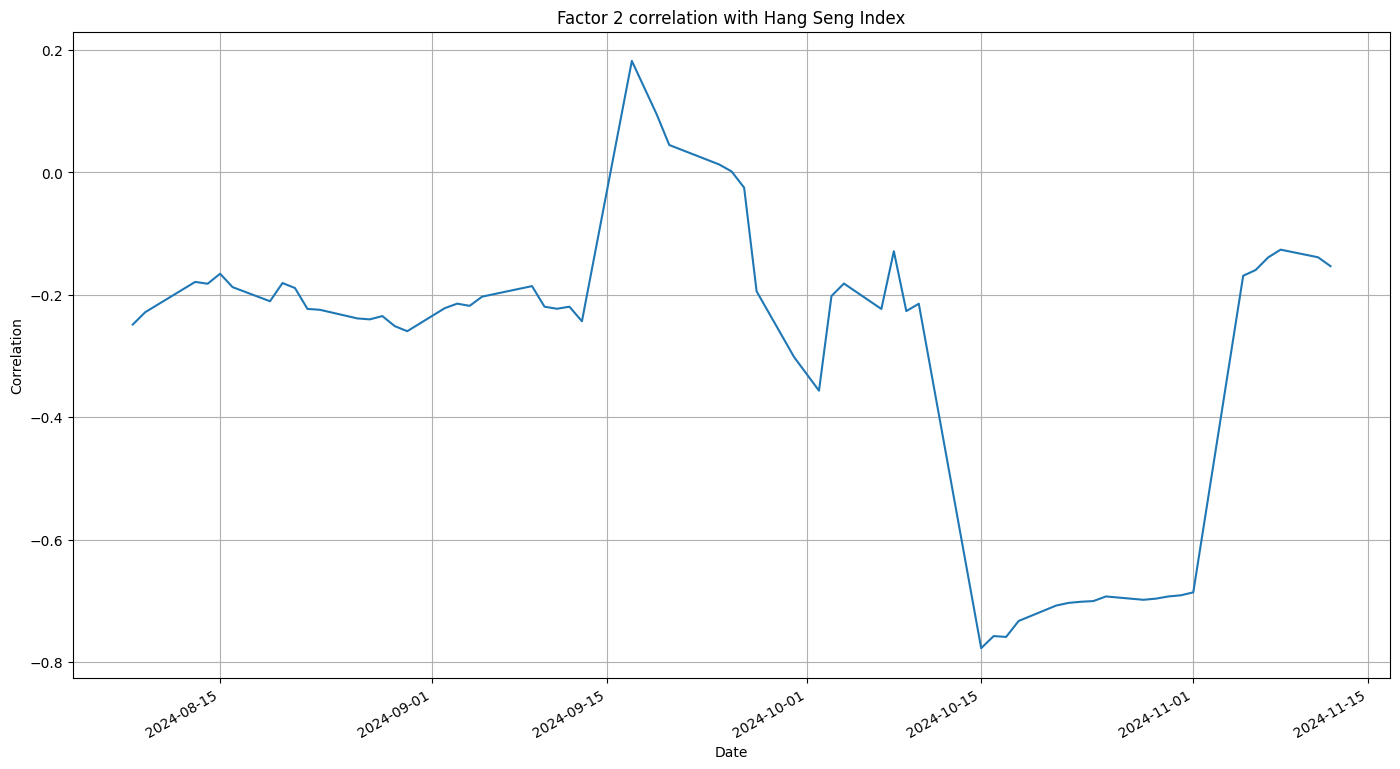

In [59]:
plt.figure(figsize=(17, 9.5))
pd.Series(corr_hang_seng['Factor 2'], index=dates[-60:]).plot()
plt.title('Factor 2 correlation with Hang Seng Index')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.show()

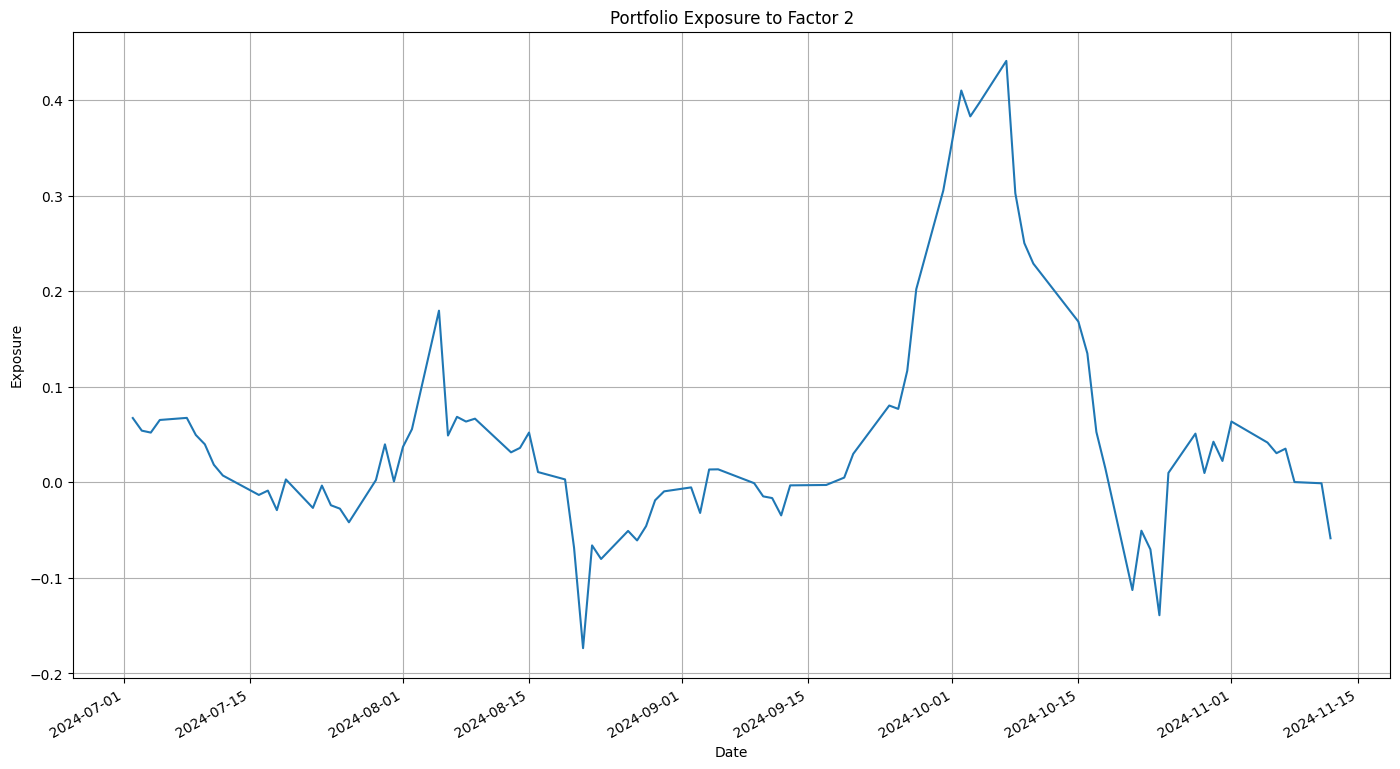

In [58]:
output_path = r"/Users/arohansharma/Desktop/Campbell-Project-Lab-Factor-PCA-PAF/asia_returns_output/"
port_betas = pd.read_excel(os.path.join(output_path, 'portBetas.xlsx'), header=0)
port_betas['Date'] = pd.to_datetime(port_betas['Date'])
port_betas.index = port_betas['Date']
port_betas_stimulus = port_betas.loc[port_betas.index > pd.Timestamp('2024-07-01')]
plt.figure(figsize=(17, 9.5))
port_betas_stimulus['Factor 2'].plot()
plt.title('Portfolio Exposure to Factor 2')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Exposure')
plt.show()